<a href="https://colab.research.google.com/github/manuhanono/test-pln-2024q1/blob/main/TP2_G8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Para realizar este proyecto se utilizó la siguiente base de datos: https://www.kaggle.com/datasets/rohanharode07/webmd-drug-reviews-dataset/data

# **Install**

In [1]:
pip install nltk pandas

In [2]:
pip install transformers torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

# **Imports**

In [3]:
import zipfile
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import altair as alt
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline
from gensim.models import Word2Vec


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score
from sklearn.model_selection import GridSearchCV

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Base**

In [5]:
df = '/content/drive/MyDrive/2024/NLP/TP-NLP/webmd.csv'

In [6]:
df = pd.read_csv(df)

# **Exploración**

In [ ]:
df.info()

In [ ]:
df.head()

In [ ]:
df.describe()

# **Valores Nulos**

In [ ]:
df.isnull().sum()

# **Valores Duplicados**

In [7]:
df.drop_duplicates()

,Age,Condition,Date,Drug,DrugId,EaseofUse,Effectiveness,Reviews,Satisfaction,Sex,Sides,UsefulCount
0,75 or over,Stuffy Nose,9/21/2014,25dph-7.5peh,146724,5,5,I'm a retired physician and of all the meds I ...,5,Male,"Drowsiness, dizziness , dry mouth /nose/thro...",0
1,25-34,Cold Symptoms,1/13/2011,25dph-7.5peh,146724,5,5,cleared me right up even with my throat hurtin...,5,Female,"Drowsiness, dizziness , dry mouth /nose/thro...",1
2,65-74,Other,7/16/2012,warfarin (bulk) 100 % powder,144731,2,3,why did my PTINR go from a normal of 2.5 to ov...,3,Female,,0
3,75 or over,Other,9/23/2010,warfarin (bulk) 100 % powder,144731,2,2,FALLING AND DON'T REALISE IT,1,Female,,0
4,35-44,Other,1/6/2009,warfarin (bulk) 100 % powder,144731,1,1,My grandfather was prescribed this medication ...,1,Male,,1
...,...,...,...,...,...,...,...,...,...,...,...,...
362801,55-64,Stop Smoking,11/14/2008,chantix,144470,5,5,I took the whole 12 weeks.I could have stopped...,5,Female,"Nausea , headache , vomiting , drowsiness, g...",2
362802,,Other,11/14/2008,chantix,144470,2,3,My dad strated taking Chantix about 1 month ag...,1,,"Nausea , headache , vomiting , drowsiness, g...",16
362803,25-34,Stop Smoking,11/13/2008,chantix,144470,2,4,"As long as I was on chantix, I didn't smoke. ...",2,Female,"Nausea , headache , vomiting , drowsiness, g...",3
362804,55-64,Stop Smoking,11/13/2008,chantix,144470,5,5,Started this medication Oct 5th 2008. Haven't ...,5,Male,"Nausea , headache , vomiting , drowsiness, g...",1


# **Modificaciones**

## Eliminar Espacios

In [8]:
for column in df:
    if df[column].dtype == 'object':
        df[column] = np.where(df[column] == " ", np.nan, df[column])

df.isna().sum()

Age              12202
Condition           43
Date                 0
Drug                 0
DrugId               0
EaseofUse            0
Effectiveness        0
Reviews          41867
Satisfaction         0
Sex              26537
Sides            17460
UsefulCount          0
dtype: int64

In [9]:
df.dropna(subset=['Reviews'], inplace=True)

In [10]:
df.dropna(subset=['Condition'], inplace=True)

## Transformar a fecha

In [11]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Year'] = df['Date'].dt.year

## Asignar con palabras clave al genero

In [12]:
#Palabras clave genero femenino
palabras_clave = ['Period', 'Birth Control','Breastfeeding','Breast','Uterine','Uterus','Cervix','Vagin','Vulva','Pregnancy','Menopause','Yeast','Cervical','Ovar','menstrual']
palabras_clave1 = ['Period', 'Birth Control','Breastfeeding','Breast','Uterine','Uterus','Cervix','Vagin','Vulva','Pregnancy','Menopause','Yeast','Cervical','Ovar','my husband and I','nursing']
filtro_condiciones = df['Condition'].str.contains('|'.join(palabras_clave), case=False, na=False)  # 'case=False' para insensibilidad a mayúsculas
filtro_condiciones1 = df['Reviews'].str.contains('|'.join(palabras_clave1), case=False, na=False)  # 'case=False' para insensibilidad a mayúsculas
filtro_condiciones2 = df['Sides'].str.contains('|'.join(palabras_clave), case=False, na=False)  # 'case=False' para insensibilidad a mayúsculas

df.loc[(filtro_condiciones | filtro_condiciones1 | filtro_condiciones2),'Sex']= 'Female'

In [13]:
#Palabras claves para genero masculino
palabras_clave_h = ['Prostate','Testis','Testicular','testicle']
palabras_clave1_h = ['Prostate','Testis','Testicular','my wife and I','penis','testicle','my son']
filtro_condiciones_h = df['Condition'].str.contains('|'.join(palabras_clave_h), case=False, na=False)  # 'case=False' para insensibilidad a mayúsculas
filtro_condiciones1_h = df['Reviews'].str.contains('|'.join(palabras_clave1_h), case=False, na=False)  # 'case=False' para insensibilidad a mayúsculas
filtro_condiciones2_h = df['Sides'].str.contains('|'.join(palabras_clave_h), case=False, na=False)  # 'case=False' para insensibilidad a mayúsculas

df.loc[(df['Sex'].isna()) & (filtro_condiciones_h | filtro_condiciones1_h| filtro_condiciones2_h),'Sex']= 'Male'

In [14]:
#Los registros restantes se ponen como genero desconocido
df['Sex'].fillna('Unknown', inplace=True)

# **Graficos**

## Barchart de Unique Values

In [15]:
uniques = pd.DataFrame({
    "columns": [col for col in df.columns if col != "Reviews"],
    "num of unique values": [df[col].nunique() for col in df.columns if col != "Reviews"]
})

bar_chart = alt.Chart(uniques).mark_bar(color='steelblue').encode(
    x=alt.X('num of unique values:Q', title='Number of Unique Values'),
    y=alt.Y('columns:N', title='Column Name', sort='-x'),
    tooltip=[alt.Tooltip('columns:N', title='Column'), alt.Tooltip('num of unique values:Q', title='Unique Values')]
).properties(
    title='Unique Values',
    width=600,
    height=300
)

text = bar_chart.mark_text(
    align='left',
    baseline='middle',
    dx=3
).encode(
    text='num of unique values:Q'
)

final_chart = alt.layer(bar_chart, text)

final_chart

alt.LayerChart(...)

## Grafico de genero

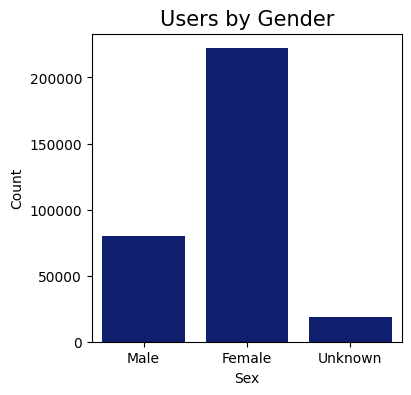

In [16]:
plt.figure(figsize = (4,4))
s=sns.countplot(x='Sex', data=df, color='#00157c')
plt.title('Users by Gender', fontsize=15)
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

## Grafico por edad

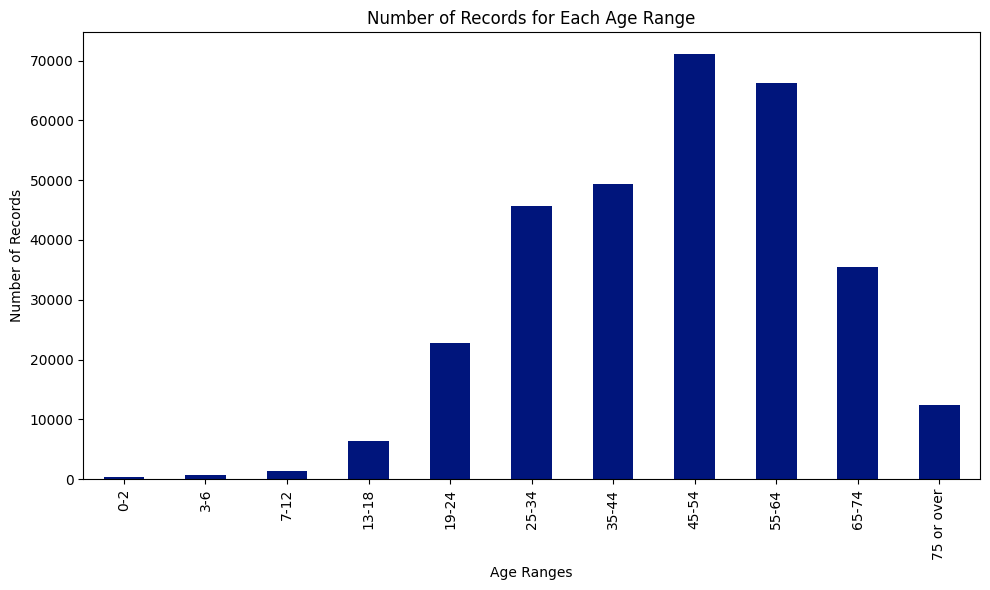

In [17]:
age_order = ['0-2', '3-6', '7-12', '13-18', '19-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 or over']

age_counts = df['Age'].value_counts().reindex(age_order)
plt.figure(figsize=(10, 6))
age_counts.plot(kind='bar', color='#00157c')
plt.title('Number of Records for Each Age Range')
plt.xlabel('Age Ranges')
plt.ylabel('Number of Records')
plt.tight_layout()
plt.show()

## Grafico por edad y genero

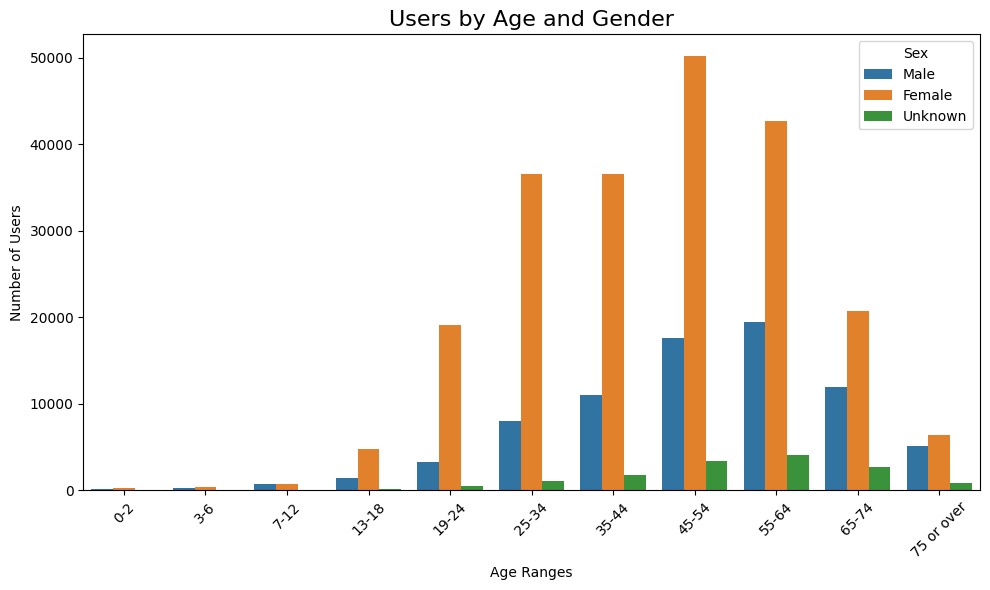

In [18]:
age_order = ['0-2', '3-6', '7-12', '13-18', '19-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75 or over']

plt.figure(figsize=(10, 6))
sns.countplot(x='Age', hue='Sex', data=df, order=age_order)
plt.title("Users by Age and Gender", fontsize=16)
plt.xticks(rotation=45)
plt.xlabel('Age Ranges')
plt.ylabel('Number of Users')
plt.legend(title='Sex', loc='upper right')
plt.tight_layout()
plt.show()

## Grafico cantidad de reviews por año

Text(0, 0.5, 'Count of Reviews')

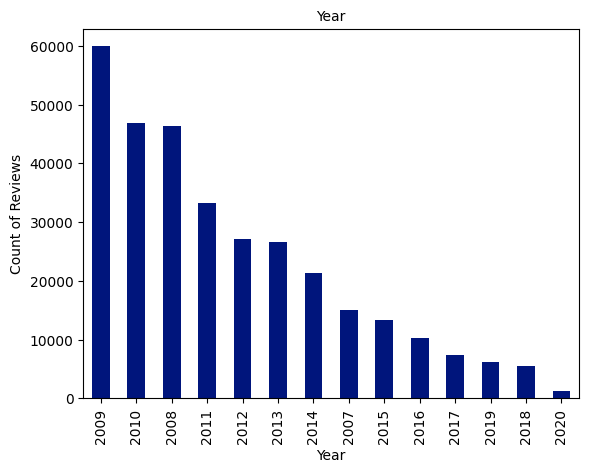

In [19]:
df['Year'].value_counts().plot(kind='bar',color='#00157c')
plt.title("Year", fontsize = 10)
plt.xlabel("Year", fontsize = 10)
plt.ylabel("Count of Reviews", fontsize = 10)

## Top 10 drogas

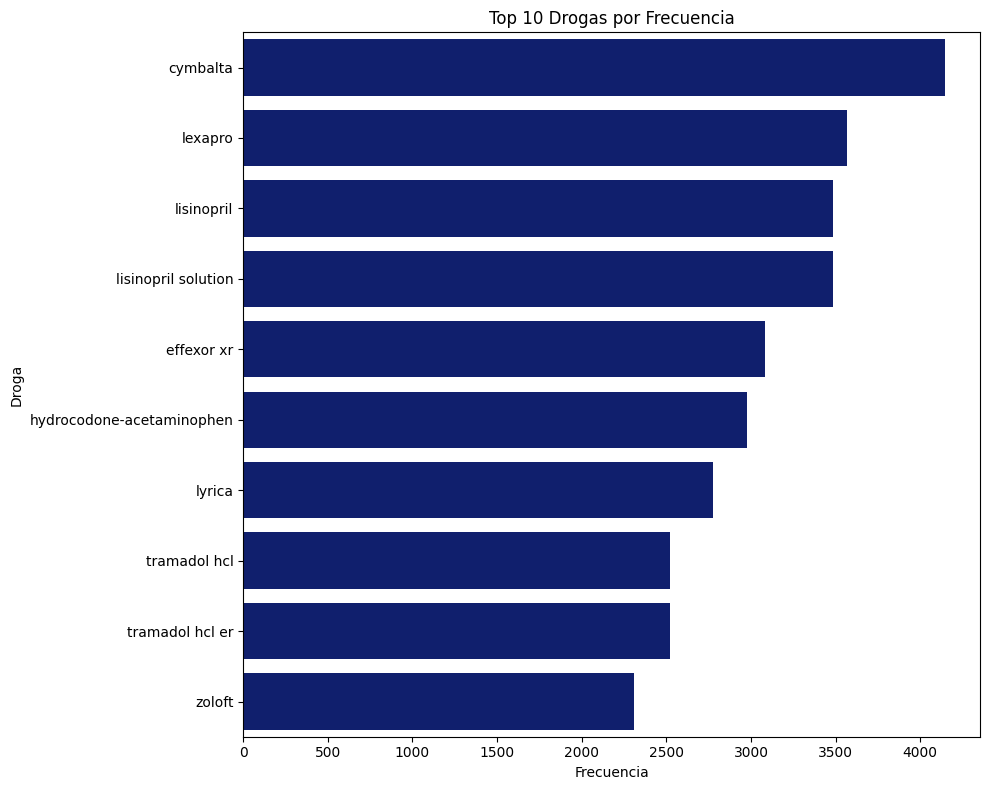

In [20]:
top_drugs = df['Drug'].value_counts().head(10).reset_index()
top_drugs.columns = ['Drug', 'Frequency']

plt.figure(figsize=(10, 8))
sns.barplot(data=top_drugs, y='Drug', x='Frequency', color='#00157c')
plt.title("Top 10 Drogas por Frecuencia")
plt.xlabel("Frecuencia")
plt.ylabel("Droga")
plt.xticks(fontsize=10)

plt.tight_layout()
plt.show()

## Top 10 conditions

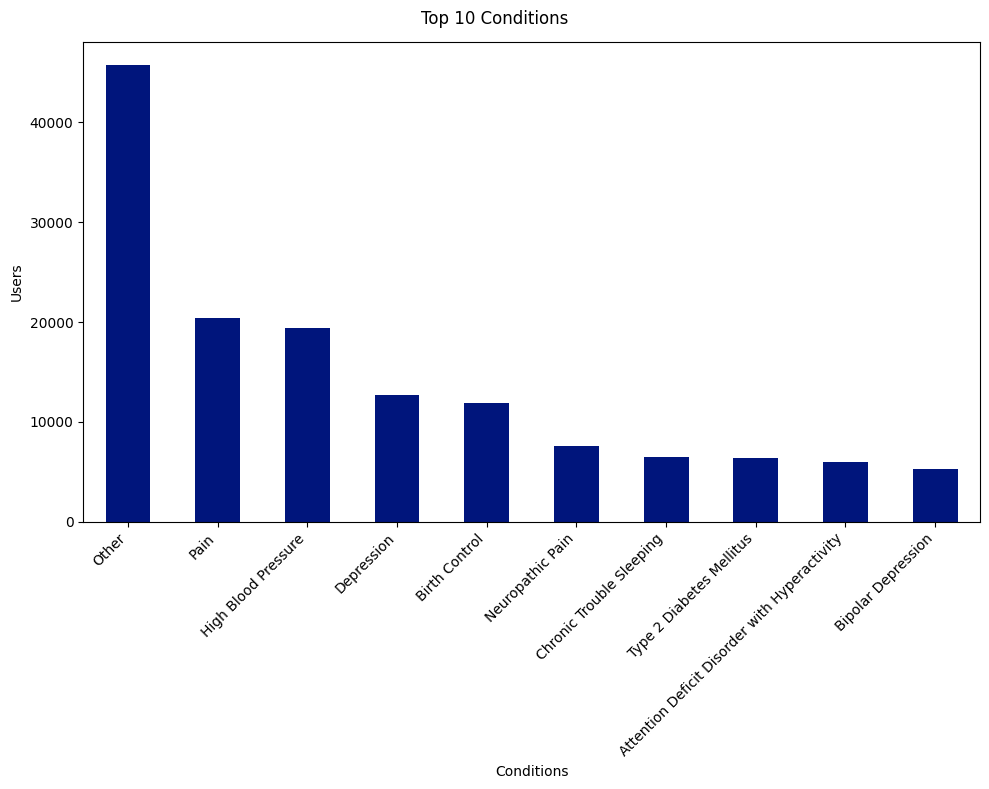

In [21]:
df['Condition'].value_counts().nlargest(10).plot(kind='bar', color='#00157c', figsize=(10, 8))  # Use a larger width for better spacing
plt.suptitle("Top 10 Conditions")
plt.xlabel('Conditions')
plt.ylabel('Users')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Rating de Effectiveness

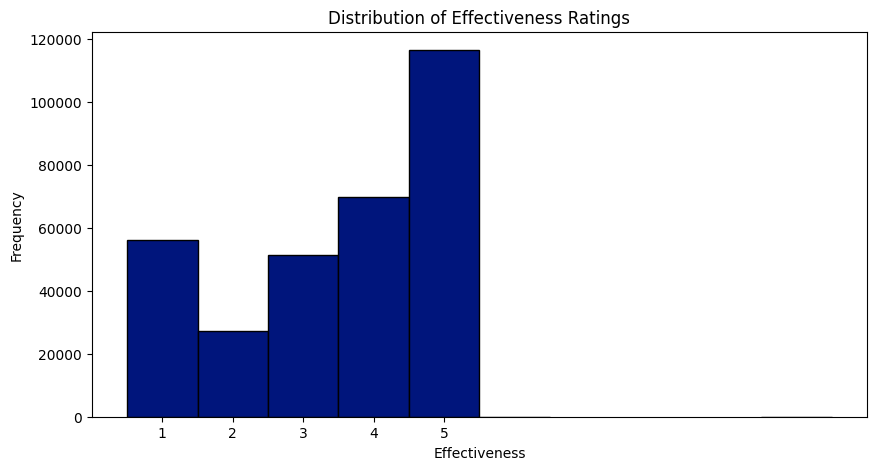

In [22]:
effectiveness_counts = df['Effectiveness'].value_counts().sort_index()

# Create the bar chart
plt.figure(figsize=(10, 5))
plt.bar(effectiveness_counts.index, effectiveness_counts.values, color='#00157c', edgecolor='black', width=1.0)
plt.title('Distribution of Effectiveness Ratings')
plt.xlabel('Effectiveness')
plt.ylabel('Frequency')
plt.xticks([1, 2, 3, 4, 5])  # Explicitly set x-ticks to ensure all categories are shown

# Show the plot
plt.show()

## Nube de palabras

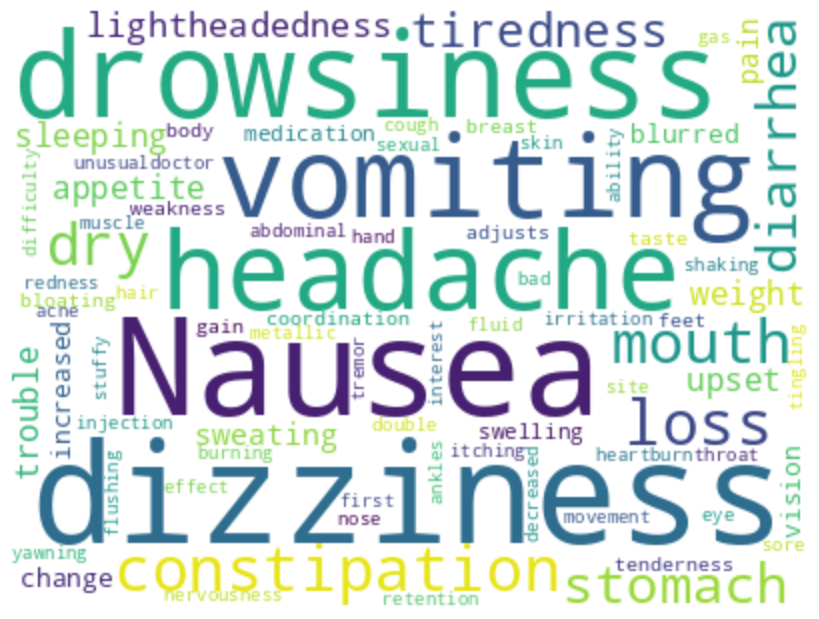

In [23]:
all_sides_text = " ".join(str(text) for text in df['Sides'] if pd.notnull(text))
custom_stopwords = set(STOPWORDS)
custom_stopwords.add("may")
custom_stopwords.add("occur")

wordcloud = WordCloud(width = 400, height = 300,
                      background_color='white',
                      stopwords=custom_stopwords,
                      collocations=False,
                      min_font_size=8).generate(all_sides_text)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

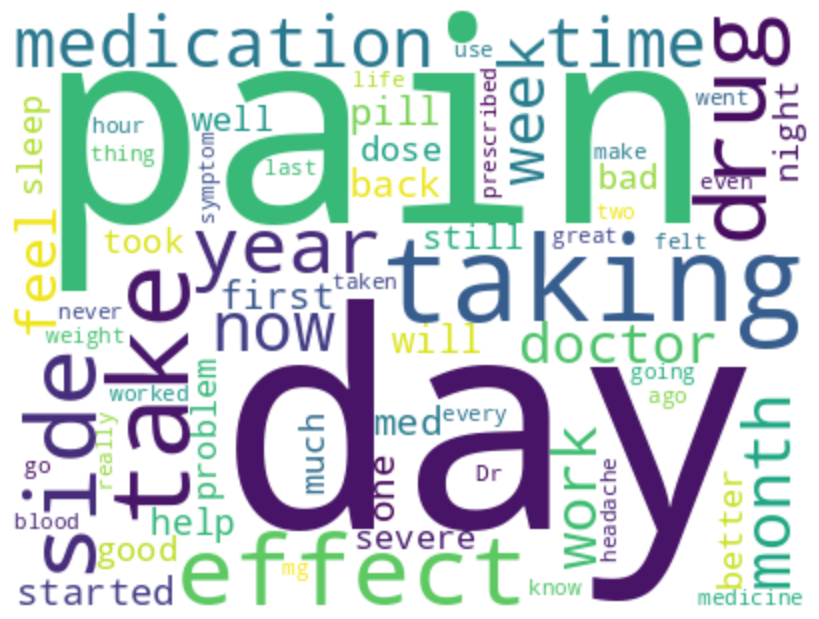

In [24]:
all_sides_text = " ".join(text for text in df.Reviews)
custom_stopwords = set(STOPWORDS)
custom_stopwords.add("day")
custom_stopwords.add("take")
custom_stopwords.add("taking")
wordcloud = WordCloud(width = 400, height = 300,
                      background_color='white',
                      collocations=False,
                      min_font_size=8).generate(all_sides_text)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

# **Sides**

In [ ]:
def trimSides(columna):
    if not isinstance(columna, str):
        return columna
    columna = re.sub(r'( or |may|also|occur|"| and | the | of |\(|\)|\.|little|bit|when you apply this medication| on |side| in )', '', columna, flags=re.IGNORECASE)

    palabras = [palabra.strip().lower() for palabra in re.split(r'[,\n]', columna)]
    palabras_reemplazadas = []
    for palabra in palabras:
        if 'dry' in palabra:
            palabra = 'dryness'
        if 'stomach' in palabra or 'abdominal' in palabra or 'tummy' in palabra or 'gas' in palabra or 'diarrhea' in palabra or 'bowel' in palabra:
            palabra = 'upset stomach'
        if 'burn' in palabra or 'sting' in palabra:
            palabra = 'burning / stinging'
        if 'itch' in palabra:
            palabra = 'itching'
        if 'taste' in palabra:
            palabra = 'change in taste'
        if 'swell' in palabra:
            palabra = 'swelling'
        if 'tired' in palabra:
            palabra = 'tiredness'
        if 'nausea' in palabra or 'vomit' in palabra:
            palabra = 'nausea'
        if 'irritation' in palabra:
            palabra = 'irritation'
        if 'vision' in palabra or 'eye' in palabra:
            palabra = 'vision problems'
        if 'skin' in palabra or 'acne' in palabra:
            palabra = 'skin issues'
        if 'dizz' in palabra or 'spin' in palabra:
            palabra = 'dizziness'
        if 'pain' in palabra:
            palabra = 'body pain'
        if 'head' in palabra:
            palabra = 'headache'
        if 'sex' in palabra or 'ejaculation' in palabra:
            palabra = 'sexual issues'
        if 'sleep' in palabra:
            palabra = 'sleep issues'
        if 'urin' in palabra:
            palabra = 'urination'
        if 'red' in palabra:
            palabra = 'redness'
        if 'shak' in palabra:
            palabra = 'shaking'
        if 'peel' in palabra:
            palabra = 'peeling'
        if 'sting' in palabra:
            palabra = 'stinging'
        if 'weight' in palabra:
            palabra = 'weight changes'
        if 'ear' in palabra:
            palabra = 'hearing issues'
        if 'sweat' in palabra:
            palabra = 'sweating'
        if 'muscle' in palabra:
            palabra = 'muscle issues'
        if 'vagin' in palabra:
            palabra = 'vaginal issues'
        if 'hair' in palabra:
            palabra = 'hair issues'
        if 'appe' in palabra:
            palabra = 'appetite'
        if 'cough' in palabra:
            palabra = 'coughing'
        if 'flush' in palabra:
            palabra = 'flushing'
        if 'breast' in palabra:
            palabra = 'breast changes'
        if 'tingling' in palabra or 'numb' in palabra:
            palabra = 'tingling'
        if 'swell' in palabra:
            palabra = 'swelling'
        if 'fever' in palabra:
            palabra = 'fever'
        if 'flu' in palabra:
            palabra = 'flu symptoms'
        if 'menstrual' in palabra:
            palabra = 'menstrual issues'
        if 'constipation' in palabra:
            palabra = 'constipation'
        if 'runny' in palabra:
            palabra = 'runny nose'
        if 'vomiting' in palabra or 'nausea' in palabra:
            palabra = 'vomiting/nausea'
        if 'injection' in palabra:
            palabra = 'injection site issues'
        if 'sore throat' in palabra:
            palabra = 'sore throat'
        if 'muscle' in palabra or 'joint' in palabra:
            palabra = 'muscle/joint issue'
        if 'flaking' in palabra:
            palabra = 'flaking skin'
        if 'eye' in palabra:
            palabra = 'eye issue'
        if 'darkening' in palabra:
            palabra = 'darkening of skin'
        if 'nosebleed' in palabra or 'nose bleed' in palabra:
            palabra = 'nosebleed'
        if 'metallic' in palabra:
            palabra = 'metallic taste'
        if 'taste' in palabra:
            palabra = 'taste change'
        if 'dream' in palabra:
            palabra = 'dreams changes'
        if 'hot' in palabra or 'flush' in palabra:
            palabra = 'hot flashes'
        if 'hoarseness' in palabra or 'hoarsenesschangesvoice' in palabra:
            palabra = 'hoarseness'
        if 'heartburn' in palabra:
            palabra = 'heartburn'
        if 'voice' in palabra:
            palabra = 'change in voice'
        if 'cramp' in palabra:
            palabra = 'cramps'
        if 'saliva' in palabra:
            palabra = 'increased saliva'
        if 'irrita' in palabra:
            palabra = 'irritation'
        if 'stool' in palabra:
            palabra = 'loose/soft stool'
        if 'mood' in palabra:
            palabra = 'mood changes'
        if 'nail' in palabra:
            palabra = 'nail changes'
        if 'sneezing' in palabra:
            palabra = 'sneezing'
        if 'walking' in palabra:
            palabra = 'problems walking'
        if 'voice' in palabra:
            palabra = 'voice changes'
        if 'doctor' in palabra or 'no' in palabra or 'usually' in palabra or len(palabra) <= 2:
            continue
        palabras_reemplazadas.append(palabra)

    return ', '.join(palabras_reemplazadas)
df['Sides2'] = df['Sides'].apply(trimSides)
print(df['Sides2'].head())

In [ ]:
side_effects = df['Sides2'].str.get_dummies(sep=',')
df_encoded = df.join(side_effects)

In [ ]:
unique_sides = []

for side in df['Sides2']:
    if isinstance(side, list):
        for palabra in side:
            if palabra not in unique_sides and palabra != '':
                unique_sides.append(palabra)

print(f'Tengo {len(unique_sides)} sides, que son: {unique_sides}')

In [ ]:
columns_to_drop = [
    "effects be caused byother medicationstheir combination",
    "effects be due to any one medicinethe combinationmedications",
    "especially atstarttreatment",
    "especially when taken at high doses",
    "especiallythe first few days as your body adjusts tomedication",
    "it be difficult to tell whether darunavir is causing certain effects",
    "rarely",
    "remember that heshe has judged thatbenefit to you is greater thanrisk effects",
    "since darunavir is always taken with other hiv medications",
    "this medication cause mild",
    "because nilutamide be used with other medications",
    "because this medication is given atsiteyour condition",
    "but then sub as your body adjusts to this medication if anythese effects persistworsen"
]
df_encoded = df_encoded.drop(columns=columns_to_drop, errors='ignore')

df_encoded.head()

# **Lematización**

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')

In [ ]:
def lemmatize_review(review):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(review)
    lemmatized_words = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_words)

In [ ]:
df['Lemmatized_Reviews'] = df['Reviews'].apply(lemmatize_review)
print(df[['Reviews', 'Lemmatized_Reviews']])

# **Word2Vec**

In [ ]:
df = df.dropna(subset=['Satisfaction', 'Lemmatized_Reviews'])

sentences = [review.split() for review in df['Lemmatized_Reviews'].astype(str)]
model = Word2Vec(sentences=sentences, vector_size=200, window=5, min_count=1, workers=4)

def vectorize_review(review, model):
    words = preprocess_text(review)
    vectors = [model.wv[word] for word in words if word in model.wv]

    if vectors:
        return sum(vectors) / len(vectors)
    else:
        return [0] * model.vector_size

df['review_vector'] = df['Lemmatized_Reviews'].apply(lambda review: vectorize_review(review, model))

X = np.vstack(df['review_vector'])
y = df['Satisfaction'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_pred_lr = regressor.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred_lr)
print(f"Mean Squared Error para Regresión Lineal: {mse_lr}")
regressor_rf = RandomForestRegressor(n_estimators=100, random_state=42)
regressor_rf.fit(X_train, y_train)
y_pred_rf = regressor_rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"Mean Squared Error para RandomForest: {mse_rf}")

y_pred_lr_rounded = np.round(y_pred_lr).clip(1, 5)
y_pred_rf_rounded = np.round(y_pred_rf).clip(1, 5)
accuracy_lr = np.mean(y_pred_lr_rounded == y_test)
print(f"Precisión para Regresión Lineal: {accuracy_lr}")
accuracy_rf = np.mean(y_pred_rf_rounded == y_test)
print(f"Precisión para RandomForest: {accuracy_rf}")

In [ ]:
def adjust_values(pred):
    return np.clip(pred, 1, 5)
y_pred_lr_adjusted = adjust_values(y_pred_lr)
y_pred_rf_adjusted = adjust_values(y_pred_rf)
diff_lr = y_pred_lr_adjusted - y_test
diff_rf = y_pred_rf_adjusted - y_test

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lr_adjusted, s=np.abs(diff_lr)*10, color='blue', alpha=0.5, label='Predicciones (RL)')
plt.scatter(y_test, y_pred_rf_adjusted, s=np.abs(diff_rf)*10, color='red', alpha=0.5, label='Predicciones (RF)')
plt.plot([1, 5], [1, 5], linestyle='--', color='gray')
plt.title('Valores Predichos vs Satisfacción')
plt.xlabel('Satisfacción Real')
plt.ylabel('Valores Predichos')
plt.legend()
plt.show()

# **Análisis de sentimientos**

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r'\W', ' ', str(text))
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    text = re.sub(r'^b\s+', '', text)
    text = text.lower()
    text = text.split()
    text = [word for word in text if word not in stop_words]
    text = ' '.join(text)
    return text

model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

df['num_tokens'] = df['Lemmatized_Reviews'].apply(lambda x: len(tokenizer.tokenize(str(x))))

df['processed_reviews'] = df.apply(lambda row: preprocess_text(str(row['Lemmatized_Reviews'])) if row['num_tokens'] > 500 else str(row['Lemmatized_Reviews']), axis=1)

nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
df['sentiment'] = df['processed_reviews'].apply(lambda x: nlp(x)[0]['label'])
sentiment_mapping = {
    '1 star': 1,
    '2 stars': 2,
    '3 stars': 3,
    '4 stars': 4,
    '5 stars': 5
}
df['sentiment_score'] = df['sentiment'].map(sentiment_mapping)

print(df.head())

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['processed_reviews'].values.astype('U'))
y = df['sentiment_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)
accuracy = accuracy_score(y_test, y_pred_rf)
report = classification_report(y_test, y_pred_rf)

print(f"Error Absoluto Medio (MAE): {mae}")
print(f"Coeficiente de Determinación (R²): {r2}")
print(f"Porcentaje de Predicciones Correctas (Exactitud): {accuracy * 100:.2f}%")
print("Reporte de Clasificación:")
print(report)


In [ ]:
rf_model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_rf_model = RandomForestClassifier(**best_params, random_state=42)
best_rf_model.fit(X_train, y_train)
y_pred_rf = best_rf_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)
accuracy = accuracy_score(y_test, y_pred_rf)
report = classification_report(y_test, y_pred_rf)

print(f"Mejores hiperparámetros: {best_params}")
print(f"Error Absoluto Medio (MAE): {mae}")
print(f"Coeficiente de Determinación (R²): {r2}")
print(f"Porcentaje de Predicciones Correctas (Exactitud): {accuracy * 100:.2f}%")
print("Reporte de Clasificación:")
print(report)

# **Recomendacion**

In [ ]:
df = df.drop(columns=['Reviews', 'Sides','sentiment'], errors='ignore')

In [ ]:
columns_to_move = ['processed_reviews', 'sentiment_score']
target_position = 13
cols = df.columns.tolist()
for col in columns_to_move:
    cols.remove(col)
for i, col in enumerate(columns_to_move):
    cols.insert(target_position + i, col)
df = df[cols]
df.info(20)

In [ ]:
df['sentiment_score'] = df['sentiment_score'].astype('float64')
df['Effectiveness'] = df['Effectiveness'].astype('float64')
df['Satisfaction'] = df['Satisfaction'].astype('float64')
print("Tipos de datos después de la conversión:")
print(df.dtypes)

In [ ]:
def filtrar_datos(df, condition, age_range, sex):
    df_filtrado = df[(df['Condition'] == condition) &
                     (df['Age'] == age_range) &
                     (df['Sex'] == sex)]
    return df_filtrado

def agregar_datos(df_filtrado):
    agregados = df_filtrado.groupby('Drug').agg({
        'sentiment_score': 'mean',
        'Effectiveness': 'mean',
        'Satisfaction': 'mean'
    }).reset_index()

    side_effects = df_filtrado.iloc[:, 15:].sum().sort_values(ascending=False).head(20)

    return agregados, side_effects

def recomendar_medicamentos(df, condition, age_range, sex):
    df_filtrado = filtrar_datos(df, condition, age_range, sex)
    if df_filtrado.empty:
        return pd.DataFrame(), pd.DataFrame()
    agregados, efectos_secundarios = agregar_datos(df_filtrado)
    recomendados = agregados.sort_values(by=['sentiment_score', 'Effectiveness', 'Satisfaction'], ascending=False)
    result_list = []
    efectos_secundarios_indices = efectos_secundarios.index.tolist()
    for _, row in recomendados.iterrows():
        drug_name = row['Drug']
        drug_side_effects = df_filtrado[df_filtrado['Drug'] == drug_name].iloc[:, 15:].sum()
        drug_side_effects = drug_side_effects.reindex(efectos_secundarios_indices, fill_value=0)
        drug_row = pd.Series([drug_name] + drug_side_effects.tolist(), index=['Drug'] + efectos_secundarios_indices)
        result_list.append(drug_row)

    result_df = pd.DataFrame(result_list)

    return recomendados, result_df

In [ ]:
condition = 'Abnormally Long or Heavy Periods'
age_range = '25-34'
sex = 'Female'

In [ ]:
recomendados, tabla_efectos_secundarios = recomendar_medicamentos(df, condition, age_range, sex)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print("\nRecomendaciones de Medicamentos:")
print(recomendados.to_string(index=False))

print("\nTabla de Recomendaciones con Efectos Secundarios:")
print(tabla_efectos_secundarios.to_string(index=False))